# Проект: Нейросеть для автодополнения текстов

## Описание
Этот проект сравнивает две модели для автодополнения текста:
1. **LSTM модель** - обучена с нуля на датасете Sentiment140
2. **DistilGPT2** - предобученная трансформерная модель

In [1]:
# Клонирование проекта в Google Collab
!git clone https://github.com/A1ienSword/text-autocomplete.git
%cd text-autocomplete/

Cloning into 'text-autocomplete'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 51 (delta 20), reused 34 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 258.14 KiB | 1.93 MiB/s, done.
Resolving deltas: 100% (20/20), done.
/content/text-autocomplete


In [2]:
# Установка зависимостей(в Google collab не хватает только библиотеки evaluate)
#%pip install -r requirements.txt
%pip install evaluate rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.4 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=19329d54632972ac8c8425dbdc3e0efb621f5793e6d98685ec00f53f2e3d7cc1
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [3]:
from datetime import datetime
import json
import logging
import random
import yaml
from pathlib import Path
from typing import Any, Dict, List, Tuple
import numpy as np
import pandas as pd
from transformers import AutoTokenizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 6)

from src.data_utils import process_dataset, split_data, get_config
from src.next_token_dataset import NextTokenDataset, collate_fn
from src.lstm_model import LSTMModel
from src.distil_gpt2_model import DistilGPT2
from src.lstm_train import train_model
from src.eval_lstm import evaluate_rouge
from src.eval_transformer_pipeline import compare_models


In [4]:
logging.basicConfig(
    filename='log.txt',
    filemode='a',
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f'Используется устройство: {device}')
logger.info(f'PyTorch версия: {torch.__version__}')

config = get_config(Path('./configs/config.yaml'))
logger.info('Конфигурация загружена')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

logger.info(f'Random seed установлен: {SEED}')

# Этап 1: Подготовка данных

## Процесс:
1. Загрузка датасета Sentiment140
2. Предобработка текстов (очистка, нормализация)
3. Токенизация с использованием BertTokenizer
4. Разбиение на train/val/test
5. Создание PyTorch Dataset'ов и DataLoader'ов

In [5]:
# Загрузка датамета
!wget -P data/ https://code.s3.yandex.net/deep-learning/tweets.txt

--2025-11-06 08:43:38--  https://code.s3.yandex.net/deep-learning/tweets.txt
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120323600 (115M) [text/plain]
Saving to: ‘data/tweets.txt’

tweets.txt          100%[===================>] 114.75M  12.8MB/s    in 10s     

2025-11-06 08:43:49 (11.5 MB/s) - ‘data/tweets.txt’ saved [120323600/120323600]



In [7]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
logger.info(f'Размер словаря: {tokenizer.vocab_size}')

logger.info('Начало обработки датасета...')
processed_texts = process_dataset(
    config_path='./configs/config.yaml',
    tokenizer=tokenizer,
    force_reprocess=False
)

logger.info(f'Всего обработано текстов: {len(processed_texts)}')
print(f'Пример обработанного текста (первые 10 токенов):')
print(f'{processed_texts[0][:10]}')

Обработка предложений c минимальной длинной 3: 100%|██████████| 1600498/1600498 [03:44<00:00, 7128.37it/s]


Пример обработанного текста (первые 10 токенов):
['aw', '##w', '##w', ',', 'that', "'", 's', 'a', 'bum', '##mer']


In [8]:
train_texts, val_texts, test_texts = split_data(
    processed_texts,
    config_path='./configs/config.yaml'
)

print('=== Размеры выборок ===')
print(f'Train set: {len(train_texts)} примеров ({len(train_texts)/len(processed_texts)*100:.1f}%)')
print(f'Val set:   {len(val_texts)} примеров ({len(val_texts)/len(processed_texts)*100:.1f}%)')
print(f'Test set:  {len(test_texts)} примеров ({len(test_texts)/len(processed_texts)*100:.1f}%)')

train_lengths = [len(t) for t in train_texts]
val_lengths = [len(t) for t in val_texts]
test_lengths = [len(t) for t in test_texts]

print('=== Статистика длин по выборкам ===')
for name, lengths in [('Train', train_lengths), ('Val', val_lengths), ('Test', test_lengths)]:
    print(f'{name:<10}: mean={np.mean(lengths):.2f}, median={np.median(lengths):.2f}, max={max(lengths)}')

=== Размеры выборок ===
Train set: 1258569 примеров (80.0%)
Val set:   157321 примеров (10.0%)
Test set:  157322 примеров (10.0%)
=== Статистика длин по выборкам ===
Train     : mean=17.79, median=16.00, max=120
Val       : mean=17.78, median=16.00, max=108
Test      : mean=17.78, median=16.00, max=116


In [9]:
train_dataset = NextTokenDataset(train_texts, tokenizer)
val_dataset = NextTokenDataset(val_texts, tokenizer)
test_dataset = NextTokenDataset(test_texts, tokenizer)

print('=== Информация о Dataset ===')
print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size:   {len(val_dataset)}')
print(f'Test dataset size:  {len(test_dataset)}')


=== Информация о Dataset ===
Train dataset size: 1258569
Val dataset size:   157321
Test dataset size:  157322


In [10]:
pad_token_id = tokenizer.pad_token_id or 0
batch_size = config['training']['batch_size']

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda b: collate_fn(b, pad_token_id)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda b: collate_fn(b, pad_token_id)
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda b: collate_fn(b, pad_token_id)
)

print('=== DataLoaderы созданы ===')
print(f'Train batches: {len(train_loader)}')
print(f'Val batches:   {len(val_loader)}')
print(f'Test batches:  {len(test_loader)}')
print(f'Batch size:    {batch_size}')
print(f'Pad token ID:  {pad_token_id}')

sample_batch = next(iter(train_loader))
print(f'=== Пример батча ===')
print(f'Input IDs shape:  {sample_batch["input_ids"].shape}')
print(f'Labels shape:     {sample_batch["labels"].shape}')

=== DataLoaderы созданы ===
Train batches: 19666
Val batches:   2459
Test batches:  2459
Batch size:    64
Pad token ID:  0
=== Пример батча ===
Input IDs shape:  torch.Size([64, 42])
Labels shape:     torch.Size([64, 42])


# Этап 2: Создание и инициализация модели
## Архитектура LSTM модели:
```
Input (token IDs)
    ↓
Embedding Layer (256 dim)
    ↓
Dropout (0.1)
    ↓
LSTM (3 layers, 256 hidden, dropout=0.2)
    ↓
Layer Normalization (опционально)
    ↓
Fully Connected (vocab_size)
    ↓
Output (logits)
```

## Параметры:
- **Embedding dimension**: 256 (размер эмбеддингов)
- **Hidden dimension**: 256 (размер скрытого состояния LSTM)
- **Number of layers**: 3 (глубина сети)
- **Dropout**: 0.2 (регуляризация)
- **Vocab size**: 30522 (BERT токенайзер)

In [ ]:
model = LSTMModel(
    vocab_size=tokenizer.vocab_size,
    embed_dim=config['model']['embed_dim'],
    hidden_dim=config['model']['hidden_dim'],
    num_layers=config['model']['num_layers'],
    pad_token_id=pad_token_id,
    dropout=config['model']['dropout'],
    embed_dropout=config['model'].get('embed_dropout', 0.1),
    bidirectional=config['model'].get('bidirectional', False),
    use_layer_norm=config['model'].get('use_layer_norm', False)
)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print('\n=== Информация о модели ===')
print(f'Total parameters:     {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(f'Model size:           {total_params * 4 / (1024**2):.2f} MB')
model = model.to(device)
print(f'Модель перемещена на устройство: {device}')


=== Информация о модели ===
Total parameters:     17,236,794
Trainable parameters: 17,236,794
Model size:           65.75 MB
Модель перемещена на устройство: cuda


# Этап 3: Обучение модели

## Процесс обучения:
1. Forward pass через батчи
2. Вычисление loss (CrossEntropyLoss)
3. Backward pass и обновление весов
4. Валидация на каждой эпохе
5. Early stopping если нет улучшений
6. Learning rate scheduling

Epoch 3/3 [Val]: 100%|██████████| 2459/2459 [00:58<00:00, 42.21it/s]


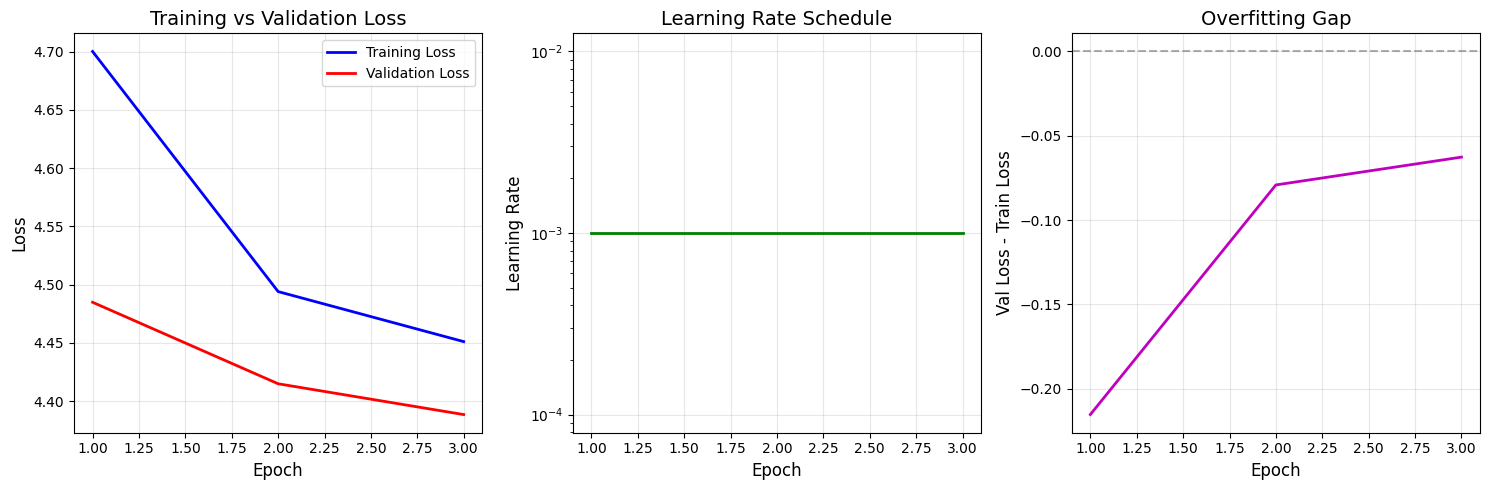

In [ ]:
trained_model = train_model(
    model,
    train_loader,
    val_loader,
    tokenizer,
    device,
    epochs=config['training']['epochs'],
    lr=config['training']['optimizer']['lr'],
    weight_decay=config['training']['optimizer']['weight_decay'],
    pad_token_id=pad_token_id,
    save_dir = config['training']['save_dir'],
    patience = config['training']['early_stopping']['patience']
)

In [ ]:
# Загрузка модели, чтобы не обучать занаво
checkpoint = torch.load('./models/best_model.pt')
trained_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Этап 4: Оценка моделей
## Метрики качества:

### ROUGE метрики
- **ROUGE-1**: Unigram overlap (совпадение одиночных слов)
- **ROUGE-2**: Bigram overlap (совпадение пар слов)
- **ROUGE-L**: Longest Common Subsequence (самая длинная общая последовательность)


In [ ]:
print('ОЦЕНКА LSTM МОДЕЛИ НА ТЕСТОВОМ НАБОРЕ')
print('='*60)

lstm_test_rouge = evaluate_rouge(
    model=trained_model,
    dataloader=test_loader,
    tokenizer=tokenizer,
    device=device,
    pad_token_id=pad_token_id,
    max_samples=2000,
    cutoff_ratio=0.75,
    temperature=0.8,
    top_k=20,
)

lstm_test_rouge1 = float(lstm_test_rouge['rouge1']) if isinstance(lstm_test_rouge['rouge1'], (int, float)) else lstm_test_rouge['rouge1']
lstm_test_rouge2 = float(lstm_test_rouge['rouge2']) if isinstance(lstm_test_rouge['rouge2'], (int, float)) else lstm_test_rouge['rouge2']
lstm_test_rougeL = float(lstm_test_rouge['rougeL']) if isinstance(lstm_test_rouge['rougeL'], (int, float)) else lstm_test_rouge['rougeL']

print(f'\nРезультаты LSTM на тесте:')
print(f'  ROUGE-1: {lstm_test_rouge1:.4f}')
print(f'  ROUGE-2: {lstm_test_rouge2:.4f}')
print(f'  ROUGE-L: {lstm_test_rougeL:.4f}')

ОЦЕНКА LSTM МОДЕЛИ НА ТЕСТОВОМ НАБОРЕ


Evaluating ROUGE:   1%|▏         | 33/2459 [00:09<12:09,  3.32it/s]



Результаты LSTM на тесте:
  ROUGE-1: 0.0332
  ROUGE-2: 0.0028
  ROUGE-L: 0.0326


In [ ]:
print('ЗАГРУЗКА ПРЕДОБУЧЕННОЙ МОДЕЛИ DISTILGPT2')
print('='*60)

baseline = DistilGPT2(device='cuda' if torch.cuda.is_available() else 'cpu')

print('Модель DistilGPT2 успешно загружена')

ЗАГРУЗКА ПРЕДОБУЧЕННОЙ МОДЕЛИ DISTILGPT2


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


Модель DistilGPT2 успешно загружена


In [12]:
print('ОЦЕНКА DISTILGPT2 НА ТЕСТОВОМ НАБОРЕ')
print('='*60)

baseline_test_rouge = baseline.evaluate_rouge(
    val_texts=test_texts,
    max_samples=2000,
    max_new_tokens=20,
    cutoff_ratio=0.75,
    do_sample=True,
    top_k=10,
    top_p=0.8,
    temperature=0.5,
    show_examples=True,
    num_examples=5
)

baseline_test_rouge1 = float(baseline_test_rouge['rouge1']) if isinstance(baseline_test_rouge['rouge1'], (int, float)) else baseline_test_rouge['rouge1']
baseline_test_rouge2 = float(baseline_test_rouge['rouge2']) if isinstance(baseline_test_rouge['rouge2'], (int, float)) else baseline_test_rouge['rouge2']
baseline_test_rougeL = float(baseline_test_rouge['rougeL']) if isinstance(baseline_test_rouge['rougeL'], (int, float)) else baseline_test_rouge['rougeL']

print(f'\nРезультаты DistilGPT2 на тесте:')
print(f'  ROUGE-1: {baseline_test_rouge1:.4f}')
print(f'  ROUGE-2: {baseline_test_rouge2:.4f}')
print(f'  ROUGE-L: {baseline_test_rougeL:.4f}')

ОЦЕНКА DISTILGPT2 НА ТЕСТОВОМ НАБОРЕ


Evaluating: 100%|██████████| 2000/2000 [02:05<00:00, 15.92it/s]



Результаты DistilGPT2 на тесте:
  ROUGE-1: 0.0094
  ROUGE-2: 0.0005
  ROUGE-L: 0.0093
